# Keywords
## En este notebook se modifica la funcion clean (que aparece en GraphOfWords.ipynb) para quedarnos unicamente con verbos. Las demas funciones se modifican para estar de acuerdo con esto.  

In [232]:
import matplotlib.pyplot as plt
import networkx as nx
import spacy
import operator
nlp = spacy.load('en')
from nltk.corpus import stopwords
from nltk import sent_tokenize
import re
import random
import collections
import string
stop_words = set(stopwords.words('english'))

## funcion que limpia los textos - ahora nos quedamos solo con los verbos

In [258]:
def majority(list_pos):
    if len(list_pos)==1:
        return list_pos[0]
    elif len(list_pos)==2:
        return random.choice(list_pos)
    else:
        C=collections.Counter(list_pos)
        most=C.most_common(1)
        return most[0][0]

def clean_verbs(text):
    text=re.sub("[\(\[].*?[\)\]]", "", text)
    sentences=sent_tokenize(text)
    sentences=[nlp(sentence) for sentence in sentences]
    sentences=[[(token.lemma_,token.pos_) for token in sentence] for sentence in sentences]
    text_pos=[item for sublist in sentences for item in sublist]
    TP=list(zip(*text_pos)) ## descomponemos text_pos en text y pos
    text=TP[0] ## texto
    pos=TP[1] ## pos asociados al texto!
    # ahora separamos los indices de todas las apariciones de las palabras unicas del texto
    unique_words=list(set(text))
    index_words=[[index for index, value in enumerate(text) if value == word] for word in unique_words]
    # ahora buscamos los pos de cada uno de los indices de index_words
    index_pos=[]
    for item in index_words:
        dict_index={text[item[0]]:[pos[i] for i in item]}
        index_pos+=[dict_index]
    # ahora con el diccionario de {palabras unicas: lista de pos} utilizamos un criterio de mayoria (solo para los verbos)
    filter_verbs={}
    for item in index_pos:
        if 'VERB' in list(item.values())[0]:
            filter_verbs[list(item.keys())[0]]=list(item.values())[0]
    for key in filter_verbs:
        filter_verbs[key]=majority(filter_verbs[key])
        
    final_text=[] ## finalmente filtramos los verbos
    for word in text:
        if word in filter_verbs.keys():
            if filter_verbs[word]=='VERB':
                final_text+=[word]
                
    final_text=[word for word in final_text if not word in stop_words]
    
    return final_text

## ejemplo

In [260]:
text='Sequencing the Neanderthal genome (Green et al., 2010, Prüfer et al., 2014), the Denisovan genome (Reich et al., 2010), and several early modern human genomes from Eurasia (Fu et al., 2014, Fu et al., 2015) has confirmed that archaic hominins left their mark in the genomes of modern humans (Plagnol and Wall, 2006, Sankararaman et al., 2014, Vernot and Akey, 2014, Vernot et al., 2016). Present-day individuals in Eurasia inherited ∼2% of their genome from Neanderthals (Green et al., 2010), and individuals from Oceania inherited ∼5% of their genome from Denisovans (Reich et al., 2010). Suggestive evidence indicates that admixture from other unidentified hominin species occurred in Africa (Hammer et al., 2011, Hsieh et al., 2016, Lachance et al., 2012, Plagnol and Wall, 2006, Wall et al., 2009). To understand the functional, phenotypic, and evolutionary consequences of archaic admixture, it is necessary to identify the specific haplotypes and alleles that were inherited from archaic hominin ancestors (Huerta-Sánchez et al., 2014, Juric et al., 2016, Sankararaman et al., 2014, Simonti et al., 2016, Vernot and Akey, 2014). Approaches to identifying introgressed haplotypes include methods that specifically incorporate reference archaic hominin genome sequences and reference-free methods that do not utilize such information. An example of the former category is the method of Sankararaman et al. (2014), which identifies archaic haplotypes by comparing modern human haplotypes to a reference archaic sequence. The latter category of methods include the S∗ statistic (Plagnol and Wall, 2006), which searches for the mutational signature that ancient admixture leaves in the genomes of present-day humans. The S∗ approach is powerful for finding introgressed haplotypes in the absence of an archaic reference genome because it leverages the unusual mutational characteristics of introgressed haplotypes. Because of the long divergence time between Neanderthals and modern humans, Neanderthals carry many alleles that are specific to their lineage. Such alleles are present on introgressed haplotypes but are absent or rare in African genomes. Further, based on the recent timing of admixture, introgressed haplotypes are expected to be maintained without recombination over distances of approximately 50 kb on average (Sankararaman et al., 2012), resulting in high levels of linkage disequilibrium (LD) between Neanderthal-specific alleles in non-African human genomes. In this study, we develop an S∗-like method that has increased power and is suitable for large-scale genome-wide data. We apply the method to large sets of sequenced data from Eurasia and Oceania and identify putative archaic-specific alleles. We examine the rate at which these alleles match the sequenced archaic genomes and the role of the genes containing these alleles, to obtain insights into the history of the admixture events and their impact on modern human genomes.'
clean_verbs(text)

['sequence',
 'confirm',
 'leave',
 'inherit',
 'inherit',
 'indicate',
 'occur',
 'understand',
 'identify',
 'inherit',
 'identify',
 'include',
 'incorporate',
 'sequence',
 'utilize',
 'identify',
 'compare',
 'sequence',
 'include',
 'search',
 'find',
 'leverage',
 'carry',
 'base',
 'expect',
 'maintain',
 'result',
 'develop',
 'increase',
 'apply',
 'sequence',
 'identify',
 'examine',
 'match',
 'sequence',
 'contain',
 'obtain']

## grafo de palabras modificado

In [261]:
# K es el largo de la ventana
# digraph indica el tipo de grafo- True = dirigido, False = no dirigido
def graph_weighted_verbs(text,K,digraph):
    text=clean_verbs(text)
    unique_words=list(set(text))
    if digraph==True: ## grafo dirigido o no dirigido
        G=nx.DiGraph()
    else:
        G=nx.Graph()
    for word in unique_words:
        G.add_node(word)
    for word in unique_words: ## recorremos el texto y encontramos los indices de todas las aparicions de word (index_word)
        index_word=[index for index, value in enumerate(text) if value == word]
        ## ahora buscamos las palabras vecinas en una ventana de largo K (hacia adelante)
        for index in index_word:
            for k in range(1,K+1):
                if index+k in range(len(text)):
                    if G.has_edge(text[index],text[index+k])==False:
                        G.add_edge(text[index],text[index+k],weight=1)
                    else:
                        x=G[text[index]][text[index+k]]['weight']
                        G[text[index]][text[index+k]]['weight']=x+1
    
    return G

In [262]:
graph_weighted_verbs(text,4,True)

## keywords segun pagerank

In [263]:
# K es el largo de la ventana
# number_keywords indica el numero de keywords
# digraph indica si queremos un grafo dirigido (True) o no dirigido (False)
def keywords_pagerank_verbs(text,number_keywords,K,digraph):
    n=len(clean_verbs(text))
    G=graph_weighted_verbs(text,K,digraph)
    keywords=nx.pagerank(G, alpha=0.85, weight='weight')
    if n<number_keywords: ## en el caso de que el texto sea muy corto (incluso menor al numero de keywords)
        number_keywords=n
    return list(list(zip(*sorted(keywords.items(), key=operator.itemgetter(1),reverse=True)))[0][:number_keywords])

In [264]:
keywords_pagerank_verbs(text,10,4,True)

['sequence',
 'identify',
 'obtain',
 'inherit',
 'include',
 'apply',
 'increase',
 'develop',
 'result',
 'maintain']

## (3) keywords segun main core

In [265]:
# K es el largo de la ventana
# digraph es el tipo de grafo - True = grafo dirigido, False = grafo no dirigido
# en esta funcion, no es necesario indicar el numero de keywords. Fijamos un maximo de 10 (esto puede ser un parametro)
def keywords_kcore_verbs(text,K,digraph):
    G=graph_weighted_verbs(text,K,digraph)
    G.remove_edges_from(nx.selfloop_edges(G)) ## evitamos ciclos para evitar que Networkx entregue un error
    main_core_nodes=list(nx.k_core(G).nodes())
    n=len(main_core_nodes)
    if n>10:
        return main_core_nodes[:10]
    else:
        return main_core_nodes

In [266]:
keywords_kcore_verbs(text,4,True)


['incorporate',
 'sequence',
 'include',
 'expect',
 'identify',
 'compare',
 'develop',
 'apply',
 'increase',
 'maintain']

## (4) visualizacion de main core de verbos

In [267]:
def visualization_maincore_verbs(text,K,digraph):
    G=graph_weighted_verbs(text,K,digraph)
    G.remove_edges_from(nx.selfloop_edges(G)) ## evitamos ciclos para evitar que Networkx entregue un error
    G=nx.k_core(G)
    G=G.to_undirected()
    G=nx.maximum_spanning_tree(G, weight='weight') ## podamos el grafo utlizando maximum spanning tree
    pos = nx.spring_layout(G)
    labels={i:i for i in G.nodes}
    nx.draw_networkx_nodes(G, pos, G.nodes, node_size = 15,node_color='r')
    nx.draw_networkx_edges(G, pos, alpha=0.5,width=0.1,edge_color='k')
    nx.draw_networkx_labels(G,pos,labels,font_size=10)
    plt.axis('off')
    plt.savefig('main_core_verbs.eps', format='eps', transparent=True, bbox_inches='tight',dpi=800)
    plt.show()

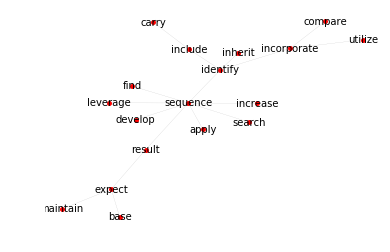

In [270]:
visualization_maincore_verbs(text,4,True)